NOTEBOOOK DE CRAETION DES ORIGINE DESTINATION LAPI

In [18]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import traitement_od as t
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os
from sklearn.cluster import DBSCAN

from sklearn import svm
from sklearn import datasets
from sklearn.cluster import spectral_clustering, AgglomerativeClustering
from sklearn import neighbors
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IMPORT DONNEES GLOBALES (SUPPRESSION DES DOUBLONS EN MM TEMPS)

In [2]:
%%time 
df_3semaines=t.ouvrir_fichier_lapi('2019-01-28 00:00:00','2019-02-17 23:59:59')
#df_3semaines=df_3semaines.drop_duplicates(['created','immat'])
df_3semaines=df_3semaines.set_index('created').sort_index()

Wall time: 1min 21s


VERIFICATION DES DONNEES

In [ ]:
#trouver les doublons
doublons=df_3semaines.reset_index()
doublons.loc[doublons.duplicated(['created','immat'],keep=False)]

In [27]:
%%time 
#verifier si des passages sont trop proches

#fonction de test d'ecart entre les passages
def ecart_passage(liste_passage, liste_camera,state) : 
    for i in range(len(liste_passage)-1):
        if (pd.to_datetime(liste_passage[i+1])-pd.to_datetime(liste_passage[i])<pd.Timedelta('00:05:00') and 
            pd.to_datetime(liste_passage[i])!=pd.to_datetime(liste_passage[i+1]) and state!='!!') : #on trouve l'enchainement en moins de 5minutes, sans prendre les doublons
            return True
    else : return False
def conserver_state(liste_state):
    if '!!' in liste_state : 
        return '!!'
    else : return liste_state[0]
def test_unicite_type(liste_l, mode='unique'):
        if mode=='unique' : 
            if len(set(liste_l))==1 :
                return liste_l[0]
            else : 
                return -1
        elif mode=='1/2' :
            if any(liste_l)==1 : 
                return 1
            else : 
                return -1
def liste_passage(liste_cam, liste_created) : 
    liste_passage=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_passage.append(liste_cam[i])
            liste_passage.append(liste_cam[i+1])
    return liste_passage
def liste_created(liste_cam, liste_created) : 
    liste_created_fin=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_created_fin.append(liste_created[i])
            liste_created_fin.append(liste_created[i+1])
    return liste_created_fin

#on grouep les données et modifie les colonnes
groupe=(df_3semaines.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x),'l': lambda x : test_unicite_type(list(x),'1/2'), 
                                                              'created':lambda x: tuple(x),'state':lambda x : conserver_state(list(x)) }))
#on isole les pl
groupe_pl=groupe.loc[groupe['l']==1].copy()
#on ajoute une colonne drapeau pour localiser le pb
groupe_pl['erreur_tps_passage']=groupe_pl.apply(lambda x :  ecart_passage(x['created'], x['camera_id'], x['state']),axis=1)
#et on extrait unqiement les passages problemetaique
groupe_pl_rappro=groupe_pl[groupe_pl['erreur_tps_passage']].copy()
groupe_pl_rappro['liste_passag_faux']=groupe_pl_rappro.apply(lambda x : liste_passage(x['camera_id'],x['created']),axis=1)
groupe_pl_rappro['liste_created_faux']=groupe_pl_rappro.apply(lambda x : liste_created(x['camera_id'],x['created']),axis=1)
#obteniur le nobre de passages concernés
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']].apply(lambda x :len(x['liste_passag_faux']),axis=1).sum()
#visu
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']]

#!!!!!!! ATTENTION : PAS DE TRAITEMENTS EFFECTUES POUR CES ERREURS POUR LE MOMENT !
#propositions : supprimer 1 des 2 occurences pour les docblons
#supprmer les plques mal lues.


In [27]:
#redresser la valeur de l
df_journee.loc[df_journee['camera_id']==15,'l']=1

LISTE DES TRAJETS

In [ ]:
#OLD
liste_trajet_locale=(pd.DataFrame([{'origine':'A63','destination':'A10','cam_o':15, 'cam_d':11, 'trajets':[
                                                        {'cameras':[15,19,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,1,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,1,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,1,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,1,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A63','cam_o':12, 'cam_d':13,'trajets':[{'cameras':[12,6,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'N10','cam_o':15, 'cam_d':5,'trajets':[{'cameras':[15,19,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,1,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,1,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,5],'type_trajet':'indirect'}, 
                                                        {'cameras':[15,5],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'N10','destination':'A63','cam_o':6, 'cam_d':13,'trajets':[{'cameras':[6,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A62','destination':'A10','cam_o':10, 'cam_d':11,'trajets':[{'cameras':[10,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A62','cam_o':12, 'cam_d':9,'trajets':[{'cameras':[12,6,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,9],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A62','destination':'N10','cam_o':10, 'cam_d':5,'trajets':[{'cameras':[10,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[10,5],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'N10','destination':'A62','cam_o':6, 'cam_d':9,'trajets':[{'cameras':[6,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[6,9],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'A62','cam_o':15, 'cam_d':9,'trajets':[{'cameras':[15,19,9],'type_trajet':'indirect'},
                                                        {'cameras':[15,9],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A62','destination':'A63','cam_o':10, 'cam_d':13,'trajets':[{'cameras':[10,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[10,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A89','destination':'A63','cam_o':8 ,'cam_d':13,'trajets':[{'cameras':[8,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'A89','cam_o':15, 'cam_d':7,'trajets':[{'cameras':[15,19,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,7],'type_trajet':'indirect'},
                                                        {'cameras':[15,7],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A89','destination':'A62','cam_o':8, 'cam_d':9,'trajets':[{'cameras':[8,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[8,9],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A62','destination':'A89','cam_o':10, 'cam_d':7,'trajets':[{'cameras':[10,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[10,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A89','destination':'A10','cam_o':8, 'cam_d':11,'trajets':[{'cameras':[8,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[8,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A89','cam_o':12, 'cam_d':7,'trajets':[{'cameras':[12,6,7],'type_trajet':'indirect'},
                                                        {'cameras':[12,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A89','destination':'N10','cam_o':8, 'cam_d':5,'trajets':[{'cameras':[8,5],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'N10','destination':'A89','cam_o':6, 'cam_d':7,'trajets':[{'cameras':[6,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A660','cam_o':12, 'cam_d':18,'trajets':[{'cameras':[12,6,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,6,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,6,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,18],'type_trajet':'direct'},
                                                        ]},
                            {'origine':'A660','destination':'A10','cam_o':19, 'cam_d':18,'trajets':[{'cameras':[19,4,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,1,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,1,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,4,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,11],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A660','destination':'A62','cam_o':19, 'cam_d':9,'trajets':[{'cameras':[19,9],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A62','destination':'A660','cam_o':10, 'cam_d':18,'trajets':[{'cameras':[10,18],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A660','destination':'A89','cam_o':19, 'cam_d':7,'trajets':[{'cameras':[19,4,7],'type_trajet':'indirect'},
                                                         {'cameras':[19,7],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A89','destination':'A660','cam_o':8, 'cam_d':18,'trajets':[{'cameras':[8,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[8,18],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'N10','destination':'A660','cam_o':6, 'cam_d':18,'trajets':[{'cameras':[6,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[6,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[6,18],'type_trajet':'direct'},
                                                        ]},
                            {'origine':'A660','destination':'N10','cam_o':19, 'cam_d':5,'trajets':[{'cameras':[19,1,5],'type_trajet':'indirect'},
                                                         {'cameras':[19,4,5],'type_trajet':'indirect'},
                                                         {'cameras':[19,5],'type_trajet':'direct'},
                                                        ]}
                           ]))[['origine', 'destination', 'cam_o', 'cam_d','trajets']]
liste_trajet_locale.to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\OLD_liste_trajets.json',orient='records')

liste_complete_trajet=pd.DataFrame([[tuple(liste_cam['cameras']),value[0],value[1],value[2],value[3],len(liste_cam['cameras'])] for obj, value in liste_trajet_locale.iterrows() for liste_cam in value[4]],
             columns=['cameras','origine','destination','cam_o','cam_d','nb_cams'])
liste_complete_trajet=liste_complete_trajet.sort_values('nb_cams',ascending=False)
liste_complete_trajet.to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\trajets_possibles.json',orient='index')
liste_complete_trajet

In [3]:
liste_complete_trajet=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\trajets_possibles.json', orient='index')
liste_complete_trajet['cameras']=liste_complete_trajet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_complete_trajet['tps_parcours_theoriq']=liste_complete_trajet.apply(lambda x : pd.Timedelta(milliseconds=x['tps_parcours_theoriq']),axis=1)
liste_complete_trajet.sort_values('nb_cams', ascending=False, inplace=True)

In [4]:
liste_complete_trajet

,cam_d,cam_o,cameras,destination,long_km,nb_cams,o_d,origine,tps_parcours_theoriq
0,11,15,"(15, 19, 4, 5, 11)",A10,120.325213,5,A63-A10,A63,01:30:14.634000
1,11,15,"(15, 19, 1, 5, 11)",A10,125.202188,5,A63-A10,A63,01:33:54.098000
13,13,12,"(12, 6, 3, 18, 13)",A63,105.139253,5,A10-A63,A10,01:18:51.266000
12,13,12,"(12, 6, 2, 18, 13)",A63,108.707013,5,A10-A63,A10,01:21:31.815000
56,7,15,"(15, 19, 4, 7)",A89,90.709158,4,A63-A89,A63,01:08:01.912000
36,11,10,"(10, 4, 5, 11)",A10,64.969553,4,A62-A10,A62,00:48:43.629000
31,13,6,"(6, 3, 18, 13)",A63,85.355597,4,N10-A63,N10,01:04:01.001000
25,5,15,"(15, 19, 1, 5)",N10,89.925738,4,A63-N10,A63,01:07:26.658000
24,5,15,"(15, 19, 4, 5)",N10,85.048763,4,A63-N10,A63,01:03:47.194000
30,13,6,"(6, 2, 18, 13)",A63,88.923357,4,N10-A63,N10,01:06:41.551000


TESTS DONNEES COMPLETES

In [5]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-28 00:00:00',7,df_3semaines)

date : 2019-01-28 00:00:00 debut_traitement : 2019-04-23 15:58:44.016332
date : 2019-01-28 01:00:00 debut_traitement : 2019-04-23 15:58:45.062848
date : 2019-01-28 02:00:00 debut_traitement : 2019-04-23 15:58:45.718943
date : 2019-01-28 03:00:00 debut_traitement : 2019-04-23 15:58:46.484366
date : 2019-01-28 04:00:00 debut_traitement : 2019-04-23 15:58:47.562242
date : 2019-01-28 05:00:00 debut_traitement : 2019-04-23 15:58:50.159439
date : 2019-01-28 06:00:00 debut_traitement : 2019-04-23 15:58:51.966954
date : 2019-01-28 07:00:00 debut_traitement : 2019-04-23 15:58:54.113203
date : 2019-01-28 08:00:00 debut_traitement : 2019-04-23 15:58:56.690694
date : 2019-01-28 09:00:00 debut_traitement : 2019-04-23 15:59:00.356557
date : 2019-01-28 10:00:00 debut_traitement : 2019-04-23 15:59:03.930235
date : 2019-01-28 11:00:00 debut_traitement : 2019-04-23 15:59:07.351348
date : 2019-01-28 12:00:00 debut_traitement : 2019-04-23 15:59:10.522463
date : 2019-01-28 13:00:00 debut_traitement : 2019-

IMPORTANT : VERIF DES DOUBLONS ENTRE LES TRAJETS

In [830]:
df_depart=dico_od.loc[dico_od['destination']=='A89'].copy()
jointure=df_depart.merge(dico_od, on='immat')
jointure=jointure.loc[jointure.date_cam_1_x!=jointure.date_cam_1_y].copy()
(jointure.loc[((jointure.date_cam_1_y>=jointure.date_cam_1_x) & (jointure.date_cam_1_y<=jointure.date_cam_2_x)) |
              ((jointure.date_cam_2_y>=jointure.date_cam_1_x) & (jointure.date_cam_2_y<=jointure.date_cam_2_x))])

DATAFRAME DES TEMPS DE PARCOURS MAX AVEC LE TYPE

In [5]:
dico_tps_max.loc[(dico_tps_max['o_d']=='A660-N10')]

,date,temps,type,o_d,cameras
0,2019-01-28 00:00:00,09:40:39,85eme_percentile,A660-N10,"(19, 4, 5)"
0,2019-01-28 02:00:00,01:55:16,85eme_percentile,A660-N10,"(19, 5)"
0,2019-01-28 06:00:00,02:04:08.250000,85eme_percentile,A660-N10,"(19, 4, 5)"
0,2019-01-28 07:00:00,00:51:56,Cluster,A660-N10,"(19, 4, 5)"
7,2019-01-28 07:00:00,00:47:07.100000,85eme_percentile,A660-N10,"(19, 5)"
4,2019-01-28 08:00:00,00:39:49,Cluster,A660-N10,"(19, 4, 5)"
5,2019-01-28 08:00:00,02:25:15.750000,85eme_percentile,A660-N10,"(19, 5)"
10,2019-01-28 08:00:00,00:40:03.700000,85eme_percentile,A660-N10,"(19, 1, 5)"
1,2019-01-28 09:00:00,00:31:39.150000,85eme_percentile,A660-N10,"(19, 5)"
3,2019-01-28 09:00:00,00:35:48,Cluster,A660-N10,"(19, 4, 5)"


CREER LE TABLEAU DE MATRICE O-D

In [4]:
#MATRICE O-D !!II!
pd.pivot_table(dico_od,values='l', index='origine', columns='destination',aggfunc='count', margins=True )

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NaN,3152.0,3197.0,2029.0,338.0,NaN,8716
A62,1271.0,NaN,243.0,778.0,632.0,1636.0,4560
A63,2477.0,144.0,NaN,NaN,718.0,13630.0,16969
A660,1475.0,711.0,NaN,NaN,1203.0,4157.0,7546
A89,278.0,847.0,1141.0,1396.0,NaN,963.0,4625
N10,NaN,1719.0,11285.0,3534.0,502.0,NaN,17040
All,5501.0,6573.0,15866.0,7737.0,3393.0,20386.0,59456


POURCENTAGE PL PAR PLAGE HORAIRE ET CAMERA

In [432]:
#isoler pl source
groupe_tv_type_simple=df_journee.groupby('immat')['l'].apply(lambda x:test_unicite_type(list(x),mode='1/2')).reset_index().drop_duplicates('immat')
df_pl=df_journee.join(groupe_tv_type_simple.loc[groupe_tv_type_simple['l']==1].set_index('immat'),on='immat',how='inner',rsuffix='_right')
df_pl.set_index('created',inplace=True)

#obtenir les nb de pl par heure et par camera sur la source
df_synthese_pl_tot=df_pl.groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_tot'})
df_synthese_pl_transit=dico_passag.set_index('created').groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_transit'})
df_pct_pl_transit=pd.concat([df_synthese_pl_tot,df_synthese_pl_transit], axis=1, join='inner')
df_pct_pl_transit.columns=[['nb_pl_tot','nb_pl_transit']]
df_pct_pl_transit['pct_pl_transit']=df_pct_pl_transit.apply(lambda x : float(x['nb_pl_transit'])*100 / x['nb_pl_tot'] ,axis=1)
df_pct_pl_transit

In [ ]:
pct_pl=t.pourcentage_pl_camera('2019-01-28 00:00:00', 1,df_3semaines.reset_index(),dico_passag)
pct_pl

VERIFICATION

In [30]:
# #retrouver une immatriculatiob dans les données completes
df_3semaines.loc[df_3semaines['immat']=='fffbb020a440bbec286fc41d4b70865e990b4bb7']

,camera_id,immat,fiability,l,state
created,,,,,
2019-02-10 09:38:43,4,fffbb020a440bbec286fc41d4b70865e990b4bb7,99,1,FR
2019-02-10 09:49:02,5,fffbb020a440bbec286fc41d4b70865e990b4bb7,99,1,FR
2019-02-10 09:50:56,10,fffbb020a440bbec286fc41d4b70865e990b4bb7,99,1,FR
2019-02-10 10:07:29,11,fffbb020a440bbec286fc41d4b70865e990b4bb7,99,0,FR


In [865]:
# retrouver une immatriculatiob dans ledico o_d
dico_od.loc[dico_od['immat']=='2da9c14f66a652882b65149a257de9f25f5a5a24']

,date_cam_1,immat,state,l,date_cam_2,cameras,origine,destination,o_d,tps_parcours


In [124]:
#verif a un horaire donne sur un trajet direct ou indirect
%time test=t.trajet(df_3semaines.loc['2019-01-29 14:00:00':'2019-01-30 23:59:59'], '2019-01-29 14:00:00', 30, [15, 5],typeTrajet='Global')

Wall time: 297 ms


In [125]:
test.temps_parcours_max

,date,temps,type,o_d,cameras
0,2019-01-29 14:00:00,01:14:53.650000,85eme_percentile,A63-N10,"(15, 5)"
1,2019-01-29 14:00:00,02:33:17,85eme_percentile,A63-A10,"(15, 19, 4, 5, 11)"
2,2019-01-29 14:00:00,01:20:36,Cluster,A63-N10,"(15, 19, 4, 5)"
3,2019-01-29 14:00:00,01:51:41.500000,85eme_percentile,A63-N10,"(15, 4, 5)"
4,2019-01-29 14:00:00,01:46:42,85eme_percentile,A63-A89,"(15, 19, 4, 7)"
5,2019-01-29 14:00:00,01:35:00,85eme_percentile,A63-A10,"(15, 4, 5, 11)"
6,2019-01-29 14:00:00,01:26:27,85eme_percentile,A63-N10,"(15, 1, 5)"
7,2019-01-29 14:00:00,01:54:23.399999,85eme_percentile,A63-N10,"(15, 19, 5)"
8,2019-01-29 14:00:00,01:17:28,85eme_percentile,A63-A89,"(15, 19, 7)"
9,2019-01-29 14:00:00,02:30:15,85eme_percentile,A63-A10,"(15, 19, 1, 5, 11)"


In [129]:
dico_graph={}
copie_df=test.df_transit.copy()
copie_df.tps_parcours=pd.to_datetime('2018-01-01')+copie_df.tps_parcours
copie_df=copie_df.merge(test.temps_parcours_max, on='cameras').drop('o_d_y',axis=1)
copie_df.temps=pd.to_datetime('2018-01-01')+copie_df.temps
print(test.df_transit.o_d.unique())

['A63-N10' 'A63-A10' 'A63-A89']


In [132]:
#for od in test.df_transit.o_d.unique() :
copie_df_tps_max=copie_df.loc[copie_df['o_d_x']=='A63-N10'][['cameras', 'temps', 'type']].drop_duplicates('temps').copy()
index_temps=pd.DataFrame(pd.DatetimeIndex(pd.date_range(start=test.date_debut, end=test.date_fin, periods=len(copie_df_tps_max))), columns=['date_cam_1'])
prod_cartesien=copie_df_tps_max.assign(key=1).merge(index_temps.assign(key=1), on='key')
points=alt.Chart(copie_df.loc[copie_df['o_d_x']=='A63-N10']).mark_point().encode(
                x='date_cam_1',
                y='hoursminutes(tps_parcours):T',
                color='cameras',
                shape='cameras',
                tooltip='hoursminutes(tps_parcours)').interactive()
line = alt.Chart(prod_cartesien).mark_line().encode(
                x='date_cam_1',
                y='hoursminutes(temps):T',
                color='cameras').interactive()

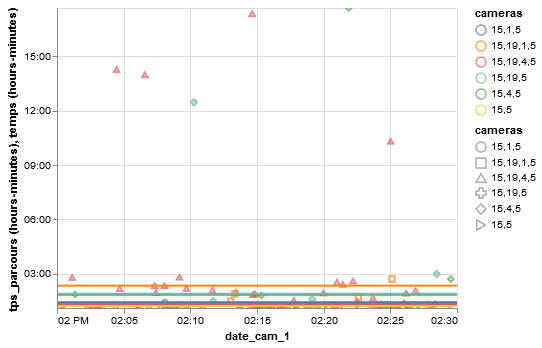

In [133]:
points+line

TESTS A LA MANO

In [135]:
#pour test des fonctions de trajets directs
df_duree=df_3semaines.loc['2019-01-29 21:00:00':'2019-01-30 15:00:00'].loc['2019-01-29 21:00:00':'2019-01-29 22:00:00']
df_duree_cam1=df_duree.loc[df_duree.loc[:,'camera_id']==19]
df_duree_autres_cam=df_3semaines.loc['2019-01-29 21:00:00':'2019-01-30 15:00:00'].loc[(df_3semaines.loc['2019-01-29 21:00:00':'2019-01-30 15:00:00'].loc[:,'immat'].isin(df_duree_cam1.loc[:,'immat']))]
cam1_croise_autre_cam=df_duree_cam1.reset_index().merge(df_duree_autres_cam.reset_index(), on='immat')
cam1_croise_suivant=cam1_croise_autre_cam.loc[(cam1_croise_autre_cam.loc[:,'created_x']<cam1_croise_autre_cam.loc[:,'created_y'])]
cam1_fastest_next=cam1_croise_suivant.loc[cam1_croise_suivant.groupby(['immat'])['created_y'].idxmin()]

In [110]:
%%time
#pour test des fonctions de trajets global

def filtrer_passage(liste, df_liste_trajet,cam) :
    """
    Récuperer les cameras qui correpondent à un trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste[:len(liste_cams)]
    else : return liste

def recuperer_date_cam2(liste,liste_created,df_liste_trajet,cam):
    """
    Récuperer les horaires de passage des cameras qui correpondent à un trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste_created[len(liste_cams)-1]
    else : return liste_created[-1]
    
def test_unicite_type(liste_l, mode='unique'):
    """test pour voir si un vehicule a ete toujours vu de la mme façon ou non
       en entre : liste de valeur de l (qui traduit si c'est u pl ou non) iisues d'une df
       en sortie : integer 0  ou 1 ou -1
       """ 
    if mode=='unique' : 
        if len(set(liste_l))==1 :
            return liste_l[0]
        else : 
            return -1
    elif mode=='1/2' :
        if any(liste_l)==1 : 
            return 1
        else : 
            return -1

camera1, camera2=19,5
df=df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59']
df_duree=df.loc['2019-01-28 14:00:00':'2019-01-28 15:00:00']
df_duree_cam1=df_duree.loc[df_duree.loc[:,'camera_id']==camera1]
df_duree_autres_cam=df.loc[(df.loc[:,'immat'].isin(df_duree_cam1.loc[:,'immat']))]
groupe=(df_duree_autres_cam.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x), 'l': lambda x : test_unicite_type(list(x),'1/2'),
                                                                               'created':lambda x: tuple(x)}))
groupe_pl=groupe.loc[groupe['l']==1].copy()
groupe_pl['camera_id']=groupe_pl.apply(lambda x : filtrer_passage(x['camera_id'],liste_complete_trajet,camera1),axis=1)#on filtre les cameras selon la liste des trajets existants
groupe_pl['created']=groupe_pl.apply(lambda x : recuperer_date_cam2(x['camera_id'],x['created'],liste_complete_trajet,camera1),axis=1)
df_ts_trajets=(groupe_pl.reset_index().merge(liste_complete_trajet[['cameras','origine','destination']],right_on='cameras', left_on='camera_id').
               rename(columns={'created':'date_cam_2'}).drop('camera_id',axis=1))
df_ts_trajets['o_d']=df_ts_trajets.apply(lambda x : x['origine']+'-'+x['destination'],axis=1)
df_agrege=df_duree_cam1.reset_index().merge(df_ts_trajets,on='immat').drop(['camera_id', 'l_x','state','fiability'],axis=1).rename(columns={'l_y':'l','created':'date_cam_1'})
df_agrege['tps_parcours']=df_agrege.apply(lambda x : x.date_cam_2-x.date_cam_1, axis=1)
df_agrege=df_agrege.loc[df_agrege['date_cam_2'] > df_agrege['date_cam_1']]

df_joint_passag_transit=df_agrege.merge(df_duree_autres_cam.reset_index(), on='immat')
df_passag_transit1=df_joint_passag_transit.loc[(df_joint_passag_transit.apply(lambda x : x['camera_id'] in x['cameras'], axis=1))]
df_passag_transit=(df_passag_transit1.loc[df_passag_transit1.apply(lambda x : x['date_cam_1']<=x['created']<=x['date_cam_2'], axis=1)]
                [['created','camera_id','immat','fiability','l_y','state']].rename(columns={'l_y':'l'}))

In [113]:
groupe_pl

,camera_id,l,created
immat,,,
002d53d08bbbd56a373f083f0b29ee2e2bc2764e,"(19, 1, 19)",1,2019-01-29 15:34:48
007f0fcd852e900369c188e360c76c66d163db61,"(15, 19, 4, 5)",1,2019-01-28 11:24:10
00bd0ffe05fd1b3a8f8276ac7b833ab8e13bac7c,"(15, 19, 4, 5, 8, 3, 18)",1,2019-01-29 10:19:19
00fba79180979dfd702b496a3a5930e486afbe04,"(19, 4, 9, 10, 9)",1,2019-01-29 18:32:47
019781ae89b9439e12222632a0d010bed6192847,"(19, 5)",1,2019-01-28 11:12:53
01e4a3018d693efa9684661098b21a39a184dfc0,"(19, 18, 19, 4, 6, 3, 9)",1,2019-01-29 19:37:50
02c39d74cf50355c06aee10eb8452081b3890b8a,"(19, 1, 2, 18, 19, 1)",1,2019-01-29 15:09:15
030bf97f38180aad2cf9fd52dda8960b4ebe24cb,"(19, 5)",1,2019-01-28 11:10:12
033bf28741b608a7bb9a731299fe2fe614e0b31c,"(19, 2, 18)",1,2019-01-28 13:19:41


TESTS

In [122]:
a660_n10=dico_od.loc[dico_od['o_d']=='N10-A63'].copy()
a660_n10=a660_n10[a660_n10.apply(lambda x : x['date_cam_1'].to_period('D')==pd.Period('2019-01-29',freq='D'), axis=1)].reset_index().drop('index', axis=1)
a660_n10.tps_parcours=pd.to_datetime('2018-01-28')+a660_n10.tps_parcours

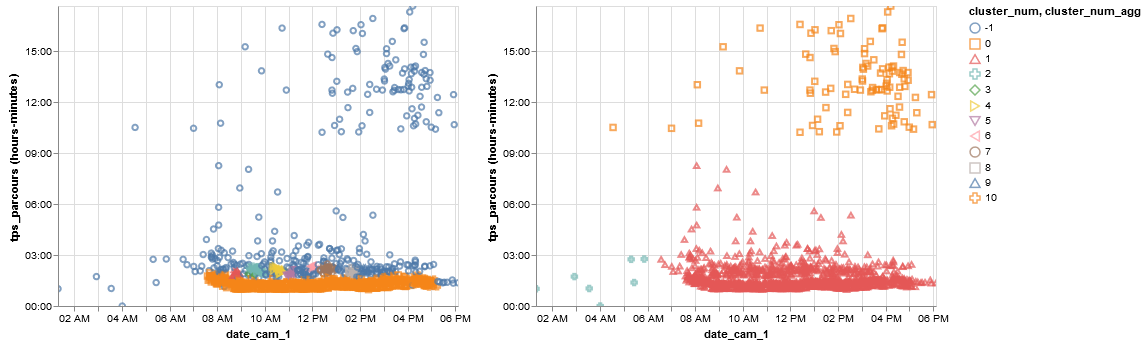

In [123]:
donnees_src=a660_n10.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
#temps_int=((pd.to_datetime('2018-01-28')+donnees_src['tps_parcours'])-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
liste_date=a660_n10.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
liste_valeur=a660_n10.tps_parcours.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
donnnes = temps_int.values
matrice=donnnes.reshape(-1, 1)
clustering=DBSCAN(eps=725, min_samples=10).fit(liste)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,a660_n10, left_on='index_base', right_index=True )

#results.tps_parcours=pd.to_datetime('2018-01-01')+results.tps_parcours
graph_tps_parcours1 = alt.Chart(results).mark_point().encode(
                            x='date_cam_1',
                            y='hoursminutes(tps_parcours)',
                            color='cluster_num:N',
                            shape='cluster_num:N',
                            tooltip='hoursminutes(tps_parcours)').interactive()

connectivity = kneighbors_graph(liste, n_neighbors=5, include_self=False)
ward = AgglomerativeClustering(n_clusters=3, 
                               linkage='average').fit(liste)
label_agg = ward.labels_
resultas = pd.DataFrame(pd.DataFrame([donnees_src.index,label_agg]).T)
resultas.columns = ['index_base', 'cluster_num_agg']
resultas = pd.merge(resultas,a660_n10, left_on='index_base', right_index=True )
#resultas.tps_parcours=pd.to_datetime('2018-01-01')+results.tps_parcours
graph_tps_parcours2 = alt.Chart(resultas).mark_point().encode(
                            x='date_cam_1',
                            y='hoursminutes(tps_parcours)',
                            color='cluster_num_agg:N',
                            shape='cluster_num_agg:N',
                            tooltip='hoursminutes(tps_parcours)').interactive()


graph_tps_parcours1 | graph_tps_parcours2

In [38]:
label = ward.labels_

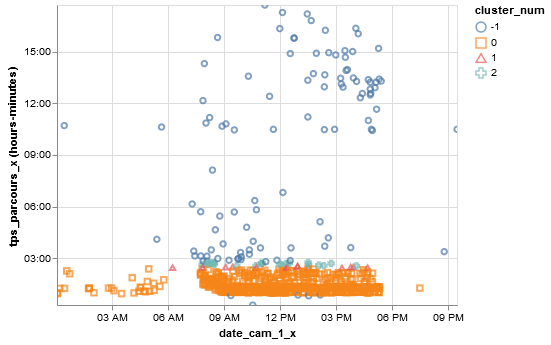

In [44]:
resultas = pd.DataFrame(pd.DataFrame([donnees_src.index,label]).T)
resultas.columns = ['index_base', 'cluster_num']
resultas = pd.merge(results,a660_n10, left_on='index_base', right_index=True )
#resultas.tps_parcours=pd.to_datetime('2018-01-01')+results.tps_parcours
graph_tps_parcours = alt.Chart(resultas).mark_point().encode(
                            x='date_cam_1_x',
                            y='hoursminutes(tps_parcours_x)',
                            color='cluster_num:N',
                            shape='cluster_num:N',
                            tooltip='hoursminutes(tps_parcours_x)').interactive()
graph_tps_parcours

In [105]:
resultas

,index_base,cluster_num_agg,date_cam_1,immat,state,l,date_cam_2,cameras,origine,destination,o_d,tps_parcours
0,0,1,2019-01-29 00:03:28,962cb29646a2dd14dbc162c8797a16af2b737c81,PT,1,2019-01-29 11:20:42,"(15, 19, 4, 5)",A63,N10,A63-N10,2018-01-28 11:17:14
1,1,1,2019-01-29 00:03:30,bebc6c3535e6bb07770d843f72dbefff7820ded5,ES,1,2019-01-29 10:21:19,"(15, 4, 5)",A63,N10,A63-N10,2018-01-28 10:17:49
2,2,1,2019-01-29 00:07:49,6db53d461d10f4014b8cdf683553b6def71023d5,PT,1,2019-01-29 10:44:39,"(15, 19, 4, 5)",A63,N10,A63-N10,2018-01-28 10:36:50
3,3,1,2019-01-29 00:11:44,bf4b33c557bf6915304b7e712c39d64ac489e113,ES,1,2019-01-29 10:28:44,"(15, 19, 4, 5)",A63,N10,A63-N10,2018-01-28 10:17:00
4,4,0,2019-01-29 00:12:25,51e47008a3d6361240f08d8d87e251858f76cad6,ES,1,2019-01-29 01:11:45,"(15, 19, 4, 5)",A63,N10,A63-N10,2018-01-28 00:59:20
5,5,0,2019-01-29 00:15:31,7315e343380ab8df86c6be2663c334ff0d8f855c,PT,1,2019-01-29 01:13:54,"(15, 19, 4, 5)",A63,N10,A63-N10,2018-01-28 00:58:23
6,6,0,2019-01-29 00:16:07,90dd06bbbc3c52b1ff59698eac6cc140d4945336,ES,1,2019-01-29 01:20:51,"(15, 4, 5)",A63,N10,A63-N10,2018-01-28 01:04:44
7,7,1,2019-01-29 00:17:20,0f5446a86477aab986dfd11d08f3a270da761092,ES,1,2019-01-29 10:34:42,"(15, 19, 4, 5)",A63,N10,A63-N10,2018-01-28 10:17:22
8,8,0,2019-01-29 00:19:34,128acd5b5346c18957608c0057b8665e45194242,BE,1,2019-01-29 01:41:47,"(15, 19, 4, 5)",A63,N10,A63-N10,2018-01-28 01:22:13
9,9,1,2019-01-29 00:28:58,e9af01ec51d1357d073b6964c57122224cb4c1e8,ES,1,2019-01-29 10:54:31,"(15, 19, 4, 5)",A63,N10,A63-N10,2018-01-28 10:25:33
